# Persistence Baseline Evaluation

## Imports & paths

In [11]:
from pathlib import Path
import json

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [12]:
ROOT = Path.cwd().parent  # adjust if notebook opened from project root
DATA_PATH = ROOT / "data" / "processed_hour.csv"
RESULTS_PATH = ROOT / "results" / "baseline_persistence_metrics.json"

## Load processed data & inspect

In [13]:
df = pd.read_csv(DATA_PATH, parse_dates=["timestamp"])
df = df.sort_values("timestamp").reset_index(drop=True)
print(df.shape)
df.head()

(17520, 26)


,timestamp,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,cnt,hour,dayofweek,is_weekend,month,year,lag_1,lag_3,lag_6,lag_24
0,2011-01-02 00:00:00,25.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,...,17.0,0,6,1,1,2011,39.0,34.0,35.0,16.0
1,2011-01-02 01:00:00,26.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,...,17.0,1,6,1,1,2011,17.0,28.0,37.0,40.0
2,2011-01-02 02:00:00,27.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,...,9.0,2,6,1,1,2011,17.0,39.0,36.0,32.0
3,2011-01-02 03:00:00,28.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0,2.0,...,6.0,3,6,1,1,2011,9.0,17.0,34.0,13.0
4,2011-01-02 04:00:00,29.0,1.0,0.0,1.0,4.0,0.0,0.0,0.0,2.0,...,3.0,4,6,1,1,2011,6.0,17.0,28.0,1.0


In [14]:
df["cnt"].describe()

count    17520.000000
mean       187.996119
std        181.383739
min          1.000000
25%         38.000000
50%        140.000000
75%        280.000000
max        977.000000
Name: cnt, dtype: float64

## Persistence predictions


In [15]:
df["prediction"] = df["cnt"].shift(1)
baseline_df = df.dropna().reset_index(drop=True)
len(baseline_df)

17519

## Metric helper

In [16]:
def regression_metrics(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return {"rmse": rmse, "mae": mae, "mape": mape}

In [17]:
metrics = regression_metrics(baseline_df["cnt"], baseline_df["prediction"])
metrics

{'rmse': 100.96639496236297,
 'mae': 64.38598093498487,
 'mape': 0.578538424055811}

In [18]:
RESULTS_PATH.parent.mkdir(exist_ok=True)
with RESULTS_PATH.open("w") as f:
    json.dump({k: float(v) for k, v in metrics.items()}, f, indent=2)
print(f"Saved metrics to {RESULTS_PATH}")

Saved metrics to C:\Users\ericb\source\bike_forecast\results\baseline_persistence_metrics.json


## Visualization

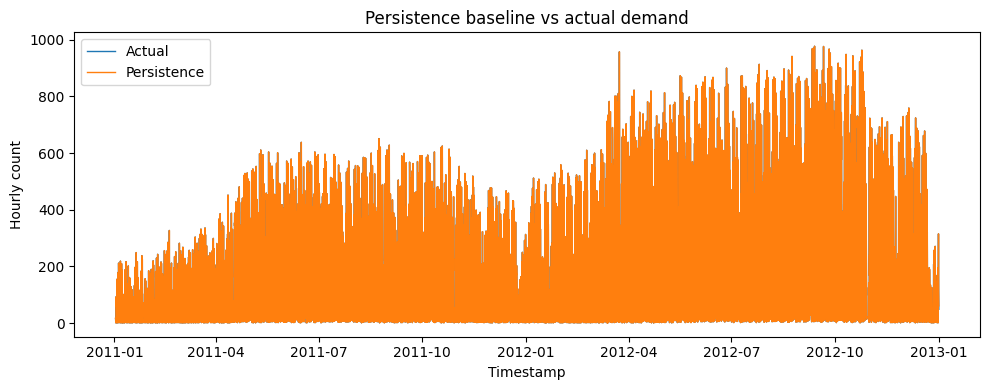

In [19]:
plt.figure(figsize=(10, 4))
plt.plot(baseline_df["timestamp"], baseline_df["cnt"], label="Actual", linewidth=1)
plt.plot(baseline_df["timestamp"], baseline_df["prediction"], label="Persistence", linewidth=1)
plt.title("Persistence baseline vs actual demand")
plt.xlabel("Timestamp")
plt.ylabel("Hourly count")
plt.legend()
plt.tight_layout()

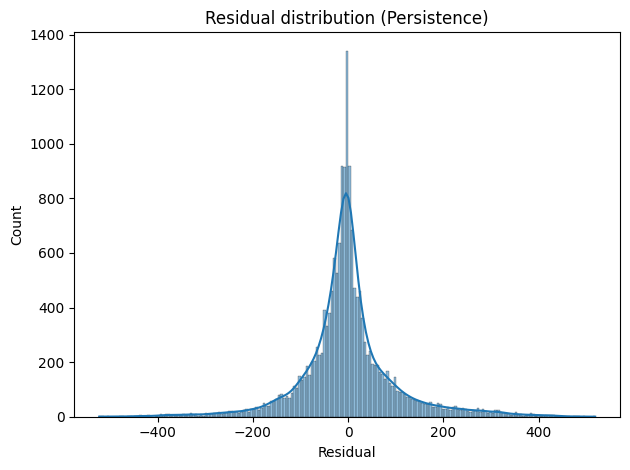

In [20]:
sns.histplot(baseline_df["cnt"] - baseline_df["prediction"], kde=True)
plt.title("Residual distribution (Persistence)")
plt.xlabel("Residual")
plt.tight_layout()

## Summary

### RMSE: 100.97
### MAE: 64.39
### MAPE: 57.85%
These persistence metrics form the benchmark each new model must surpass to demonstrate meaningful improvement in predictive accuracy.